## MACHINE LEARNING TECHNIQUES - FORMATIVE ASSIGNMENT

## TRANSFER LEARNING

In [1]:
# Setup
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

import datetime

import tf_keras

2024-09-10 23:27:54.175938: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## An ImageNet classifier      

Here, we use a classifier pre-trained on the ImageNet dataset. ImageNet is a large benchmark dataset often used 
for transfer learning, where models trained on it can be adapted to new tasks.


## Download the classifier      

We're selecting a MobileNetV2 model from TensorFlow Hub and wrapping it as a Keras layer. MobileNetV2 is a popular 
model due to its efficiency and relatively small size, making it well-suited for mobile and embedded applications.

In [2]:
# Models
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"
resnet_50 = "https://tfhub.dev/tensorflow/resnet_50/classification/1"

# Use MobileNetV2 first
classifier_model = mobilenet_v2

In [3]:
# Define the image size expected by the model (224x224 pixels)
IMAGE_SHAPE = (224, 224)

# Create a Sequential model with the pre-trained MobileNetV2 classifier
classifier = tf_keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

We define the input shape (224x224 pixels with 3 color channels), which is required by MobileNetV2.      
The Keras Sequential API is used to construct the model by wrapping the pre-trained model from TensorFlow Hub. 

## Run it on a single image     

Now, we will download a sample image to test our pre-trained classifier.

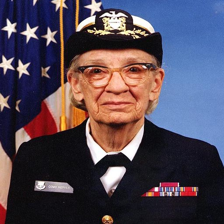

In [4]:
# Download and preprocess the image
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [5]:
# Normalize the pixel values by dividing by 255 (as MobileNet expects normalized inputs)
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

The image is resized to match the input dimensions required by the model and normalized to a [0, 1] range, 
which helps the model interpret the pixel values correctly.

In [6]:
# Add a batch dimension and pass the image to the model
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

1/1 [==============================] - 17s 17s/step


(1, 1001)

Since the model expects batches of images, we add an extra dimension to our image array using `np.newaxis`.       
The model returns a 1001-element vector (as ImageNet has 1000 classes + 1 background class).

In [7]:
# Find the top class prediction
predicted_class = tf.math.argmax(result[0], axis=-1)
predicted_class

<tf.Tensor: shape=(), dtype=int64, numpy=653>

We use `tf.math.argmax` to get the index of the class with the highest predicted probability.      
This is the model's best guess for what the image represents.

## Decode the predictions     

Finally, we map the predicted class ID to a human-readable label using the ImageNet class labels.


In [8]:
# Download the ImageNet labels
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

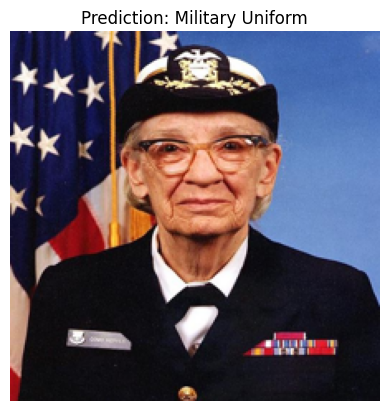

In [9]:
# Display the image with the predicted class label
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

We fetch the corresponding label from ImageNet using the predicted class ID and display the image 
along with the predicted label, allowing us to visualize the prediction made by the model.
Now that we have evaluated how the mobilenetv2 works, let us do the transfer learning.

## Dataset for Our new model

THE CIFAR-10 DATASET: it is a dataset of 50,000 32x32 color training images and 10,000 test images, labeled over 10 categories.

In [10]:
# Load the full CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# the percentage of data that we want to use (10%)
data_percentage = 0.1

# Calculate the number of samples to load
train_samples = int(x_train.shape[0] * data_percentage)
test_samples = int(x_test.shape[0] * data_percentage)

# Select only a subset of the training and testing data
x_train_subset = x_train[:train_samples]
y_train_subset = y_train[:train_samples]
x_test_subset = x_test[:test_samples]
y_test_subset = y_test[:test_samples]

# validation data
x_val = x_train_subset[:1000]
y_val = y_train_subset[:1000]

# Confirm the shapes of the subsets
print(f"Training data shape: {x_train_subset.shape}, Labels shape: {y_train_subset.shape}")
print(f"Test data shape: {x_test_subset.shape}, Labels shape: {y_test_subset.shape}")
print(f"Validation data shape: {x_val.shape}, Labels shape: {y_val.shape}")

Training data shape: (5000, 32, 32, 3), Labels shape: (5000, 1)
Test data shape: (1000, 32, 32, 3), Labels shape: (1000, 1)
Validation data shape: (1000, 32, 32, 3), Labels shape: (1000, 1)


I realised that I had to resize the images from 32 * 32 to 224 * 224 in order to match the input shape of our model.

In [11]:
# Resize the images to match the input shape of the model
x_train_resized = tf.image.resize(x_train_subset, IMAGE_SHAPE)
x_test_resized = tf.image.resize(x_test_subset, IMAGE_SHAPE)
x_val_resized = tf.image.resize(x_val, IMAGE_SHAPE)

# check the shape of the resized images
print(x_train_resized.shape)
print(x_test_resized.shape)
print(x_val_resized.shape)

(5000, 224, 224, 3)
(1000, 224, 224, 3)
(1000, 224, 224, 3)


In [12]:
# the class names are not included with the dataset, so we'll specify them here
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# # Normalize the pixel values by dividing by 255S


In [13]:
x_train_normalized = x_train_resized / 255.0
x_test_normalized = x_test_resized / 255.0
x_val_normalized = x_val_resized / 255.0
print(x_train_normalized.shape)
print(x_test_normalized.shape)
print(x_val_normalized.shape)

(5000, 224, 224, 3)
(1000, 224, 224, 3)
(1000, 224, 224, 3)


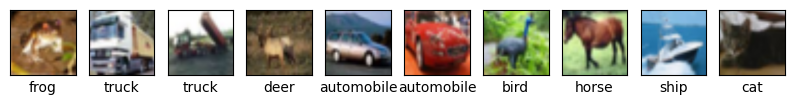

In [14]:
# Display the first 10 images from the training set and display the class name below each image
plt.figure(figsize=(10, 1))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train_normalized[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

## FEATURE EXTRACTION      

Create the feature extractor by wrapping the pre-trained model as a Keras layer with hub.KerasLayer. And, use the trainable=False argument to freeze the variables, so that the training only modifies the new classifier layer      


## 1st Model: MobileNetV2    

In [15]:
# Load the MobileNetV2 model withoout the top classification layer
pretrained_base = hub.KerasLayer(classifier_model, input_shape=(224, 224, 3), trainable=False)

# layers for fine-tuning
model = tf_keras.Sequential([
    pretrained_base,
    tf_keras.layers.Flatten(),
    tf_keras.layers.Dense(1024, activation='relu'),
    tf_keras.layers.Dense(512, activation='relu'),
    tf_keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
start = datetime.datetime.now()
model.fit(x_train_normalized, y_train_subset, epochs=2, validation_data=(x_val_normalized, y_val))
end = datetime.datetime.now()


Epoch 1/2
157/157 [==============================] - 316s 2s/step - loss: 0.8223 - accuracy: 0.7324 - val_loss: 0.3817 - val_accuracy: 0.8690
Epoch 2/2
157/157 [==============================] - 199s 1s/step - loss: 0.4389 - accuracy: 0.8442 - val_loss: 0.3255 - val_accuracy: 0.8990


In [16]:
# evaluate the model
model.evaluate(x_test_normalized, y_test_subset)

32/32 [==============================] - 32s 944ms/step - loss: 0.6691 - accuracy: 0.7810


[0.6691061854362488, 0.781000018119812]

## Detailed Performance Metric


32/32 [==============================] - 141s 4s/step


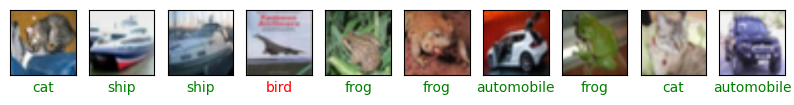

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
# predict the data on the mobileNetV2 model
predicted = model.predict(x_test_normalized)

# Display the first 10 images from the test set and display the predicted class name below each image
plt.figure(figsize=(10, 1))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test_normalized[i], cmap=plt.cm.binary)
    predicted_label = np.argmax(predicted[i])
    true_label = y_test_subset[i][0]
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    plt.xlabel(f'{class_names[predicted_label]}', color=color)
plt.show()

In [19]:
# print classification report
print(classification_report(y_test_subset, np.argmax(predicted, axis=1), target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.62      0.86      0.72       103
  automobile       0.85      0.82      0.83        89
        bird       0.77      0.74      0.76       100
         cat       0.73      0.54      0.62       103
        deer       0.77      0.83      0.80        90
         dog       0.74      0.70      0.72        86
        frog       0.86      0.91      0.88       112
       horse       0.75      0.86      0.80       102
        ship       0.83      0.79      0.81       106
       truck       0.98      0.73      0.84       109

    accuracy                           0.78      1000
   macro avg       0.79      0.78      0.78      1000
weighted avg       0.79      0.78      0.78      1000



### Result Visualisation


([], [])

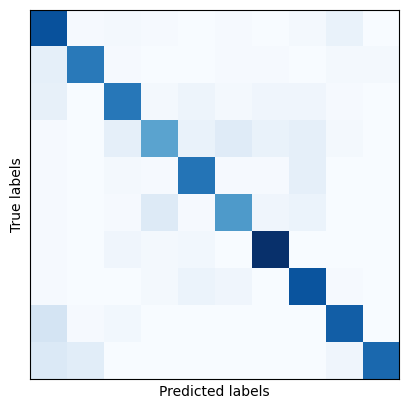

In [20]:
from sklearn.metrics import confusion_matrix

# Plot the confusion matrix
cm = confusion_matrix(y_test_subset, np.argmax(predicted, axis=1))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])

## 2ND MODEL: ResNet50


In [21]:
# URLs for the pre-trained models from TensorFlow Hub
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
resnet_50 = "https://tfhub.dev/tensorflow/resnet_50/classification/1"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"


second_classifier_model = resnet_50
third_classifier_model = inception_v3

In [22]:
# Create a Sequential model with the pre-trained ResNet-50 classifier
second_classifier = tf_keras.Sequential([
    hub.KerasLayer(second_classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

# layers for fine-tuning
second_model = tf_keras.Sequential([
    second_classifier,
    tf_keras.layers.Flatten(),
    tf_keras.layers.Dense(1024, activation='relu'),
    tf_keras.layers.Dense(512, activation='relu'),
    tf_keras.layers.Dense(10, activation='softmax')
])

# Compile the model
second_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
start = datetime.datetime.now()
second_model.fit(x_train_normalized, y_train_subset, epochs=2, validation_data=(x_val_normalized, y_val))
end = datetime.datetime.now()

Epoch 1/2
157/157 [==============================] - 1672s 10s/step - loss: 1.0131 - accuracy: 0.6920 - val_loss: 0.5540 - val_accuracy: 0.8020
Epoch 2/2
157/157 [==============================] - 1063s 7s/step - loss: 0.5951 - accuracy: 0.7950 - val_loss: 0.4810 - val_accuracy: 0.8250


In [23]:
# evaluate the model
second_model.evaluate(x_test_normalized, y_test_subset)

32/32 [==============================] - 192s 6s/step - loss: 0.7337 - accuracy: 0.7600


[0.7336881756782532, 0.7599999904632568]

## Detailed Performance Metrics

32/32 [==============================] - 198s 6s/step


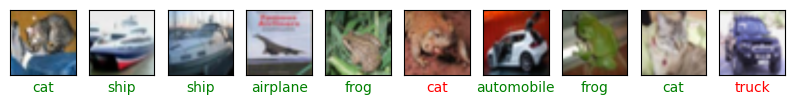

In [24]:
# predict the data on the second model
second_predicted = second_model.predict(x_test_normalized)

# Display the first 10 images from the test set and display the predicted class name below each image
plt.figure(figsize=(10, 1))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test_normalized[i], cmap=plt.cm.binary)
    predicted_label = np.argmax(second_predicted[i])
    true_label = y_test_subset[i][0]
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    plt.xlabel(f'{class_names[predicted_label]}', color=color)

plt.show()

In [25]:
# print classification report
print(classification_report(y_test_subset, np.argmax(second_predicted, axis=1), target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.82      0.78      0.80       103
  automobile       0.88      0.66      0.76        89
        bird       0.80      0.68      0.74       100
         cat       0.56      0.73      0.63       103
        deer       0.62      0.80      0.70        90
         dog       0.73      0.66      0.70        86
        frog       0.77      0.88      0.82       112
       horse       0.95      0.62      0.75       102
        ship       0.90      0.89      0.89       106
       truck       0.76      0.85      0.81       109

    accuracy                           0.76      1000
   macro avg       0.78      0.76      0.76      1000
weighted avg       0.78      0.76      0.76      1000



([], [])

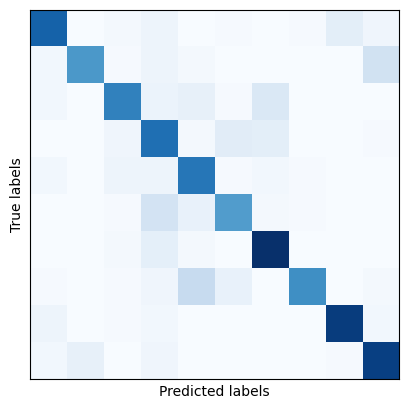

In [26]:
# Plot the confusion matrix
cm = confusion_matrix(y_test_subset, np.argmax(second_predicted, axis=1))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])

## 3RD MODEL: InceptionV3

In [27]:
# Create a Sequential model with the pre-trained InceptionV3 classifier
third_classifier = tf_keras.Sequential([
    hub.KerasLayer(third_classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

# layers for fine-tuning
third_model = tf_keras.Sequential([
    third_classifier,
    tf_keras.layers.Flatten(),
    tf_keras.layers.Dense(1024, activation='relu'),
    tf_keras.layers.Dense(512, activation='relu'),
    tf_keras.layers.Dense(10, activation='softmax')
])

# Compile the model
third_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
start = datetime.datetime.now()
third_model.fit(x_train_normalized, y_train_subset, epochs=2, validation_data=(x_val_normalized, y_val))
end = datetime.datetime.now()

Epoch 1/2
157/157 [==============================] - 719s 4s/step - loss: 0.7599 - accuracy: 0.7702 - val_loss: 0.3634 - val_accuracy: 0.8890
Epoch 2/2
157/157 [==============================] - 700s 4s/step - loss: 0.3539 - accuracy: 0.8786 - val_loss: 0.2099 - val_accuracy: 0.9250


In [28]:
# evaluate the model
third_model.evaluate(x_test_normalized, y_test_subset)

32/32 [==============================] - 107s 3s/step - loss: 0.5883 - accuracy: 0.8010


[0.5883493423461914, 0.8009999990463257]

## Detailed Performance Metrics

32/32 [==============================] - 106s 3s/step


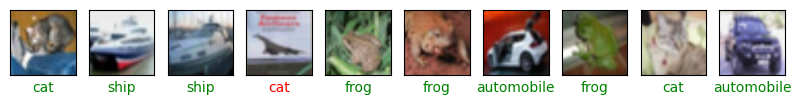

In [29]:
# predict the data on the third model
third_predicted = third_model.predict(x_test_normalized)

# Display the first 10 images from the test set and display the predicted class name below each image
plt.figure(figsize=(10, 1))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test_normalized[i], cmap=plt.cm.binary)
    predicted_label = np.argmax(third_predicted[i])
    true_label = y_test_subset[i][0]
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    plt.xlabel(f'{class_names[predicted_label]}', color=color)

plt.show()

In [30]:
# print classification report
print(classification_report(y_test_subset, np.argmax(third_predicted, axis=1), target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.86      0.59      0.70       103
  automobile       0.83      0.92      0.87        89
        bird       0.74      0.80      0.77       100
         cat       0.68      0.76      0.72       103
        deer       0.72      0.74      0.73        90
         dog       0.82      0.72      0.77        86
        frog       0.79      0.92      0.85       112
       horse       0.89      0.82      0.86       102
        ship       0.78      0.92      0.85       106
       truck       0.96      0.79      0.86       109

    accuracy                           0.80      1000
   macro avg       0.81      0.80      0.80      1000
weighted avg       0.81      0.80      0.80      1000



([], [])

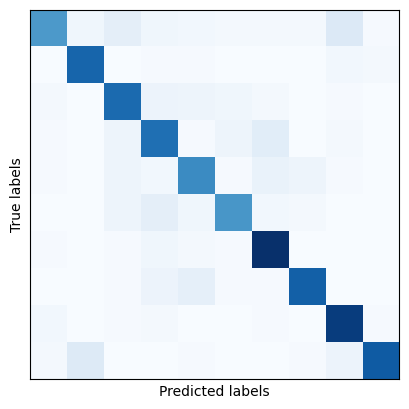

In [31]:
# Plot the confusion matrix
cm = confusion_matrix(y_test_subset, np.argmax(third_predicted, axis=1))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
